In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torch

import torchvision
import time

from model import VAE, IVAE
from train import train_geco, train_beta
from utils import sample_vae, marginal_KL, Compute_NLL
import datasets
# from GECO import *
# from beta_vae import *
torch.cuda.set_device(5)


%matplotlib inline

In [2]:
!nvidia-smi

Fri Oct 26 17:47:08 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   37C    P0    40W / 250W |  15622MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |  14026MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [4]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(3 * n_col, 1.9 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [5]:
dataset = 'mnist'

if dataset == 'mnist':
    train_set = datasets.MNIST('./data/'+dataset+'/',  download=True, train=True, \
                                            transform=torchvision.transforms.ToTensor())
    test_set = datasets.MNIST('./data/'+dataset+'/',  download=True, train=False, \
                                            transform=torchvision.transforms.ToTensor())
    input_size = (28, 28)
    
elif dataset == 'cifar10':
    train_set = datasets.CIFAR10('./data/'+dataset+'/',  download=True, train=True, \
                                            transform=torchvision.transforms.ToTensor())
    test_set = datasets.CIFAR10('./data/'+dataset+'/',  download=True, train=False, \
                                            transform=torchvision.transforms.ToTensor())
    input_size = (32, 32)
else:
    train_set = datasets.CELEBA('./data/'+dataset+'/', train=True, \
                                            transform=torchvision.transforms.ToTensor())
    test_set = datasets.CELEBA('./data/'+dataset+'/',  train=False, \
                                            transform=torchvision.transforms.ToTensor())
    input_size = (218,178)
    
    
batch_size = 300
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
vae_model_geco =  VAE(dims = [28*28, 512, 256], dim_latent = 200)
vae_model_geco.to(device)

optimizer = optim.Adam(vae_model_geco.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
scheduler = None
train_geco(vae_model_geco, optimizer, scheduler, 
           train_loader = train_loader, 
           valid_loader = test_loader, 
           device = device, lbd_step = 100, 
           num_epochs=200,lambd_init = torch.FloatTensor([0.5]),
           tol = 4)

In [8]:
vae_model_beta1 =  VAE(dims = [28*28, 512, 256], dim_latent = 200)
vae_model_beta1.to(device)

optimizer = optim.Adam(vae_model_beta1.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
train_beta(vae_model_beta1, optimizer, scheduler, train_loader, 
           test_loader, num_epochs=50, beta=1)

In [6]:
ivae_model = torch.load('IWAE.dab').to(device)
vae_model_beta05 = torch.load('beta05.dab').to(device)
vae_model_beta1 = torch.load('beta1.dab').to(device)
vae_model = torch.load('geco.dab').to(device)

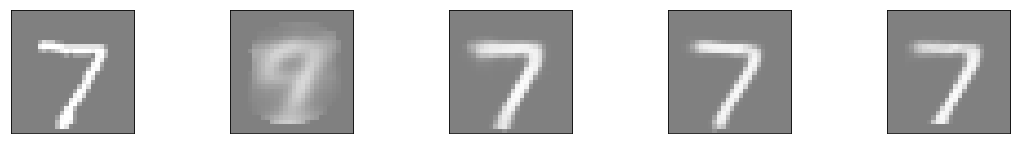

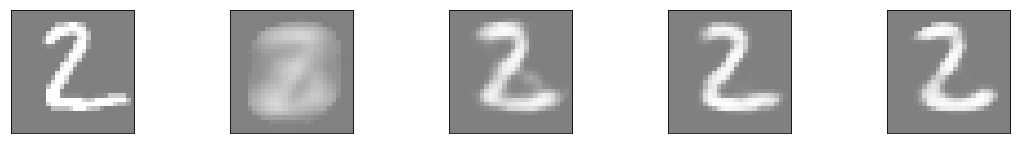

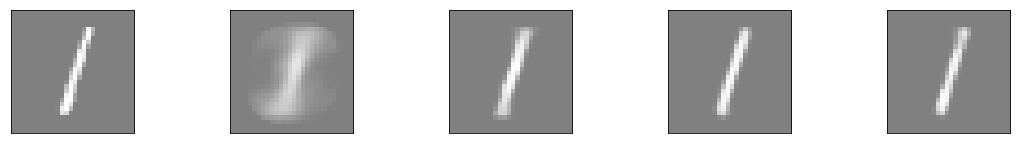

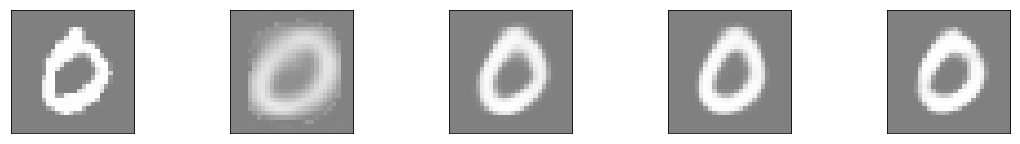

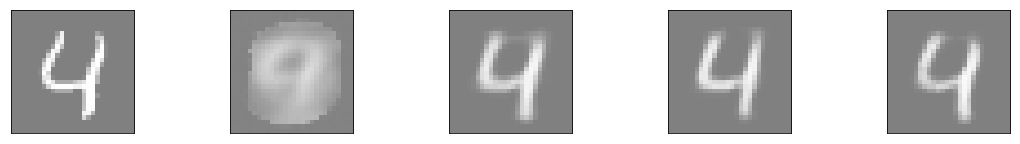

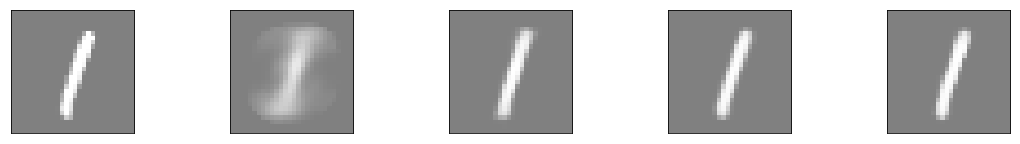

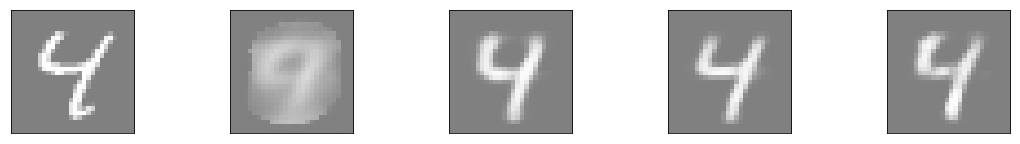

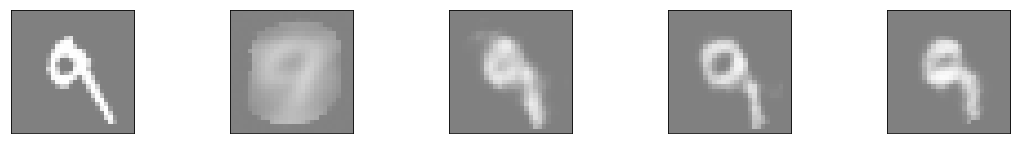

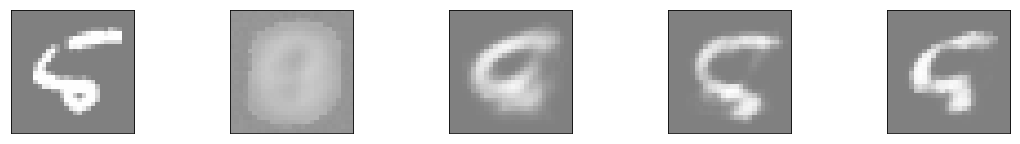

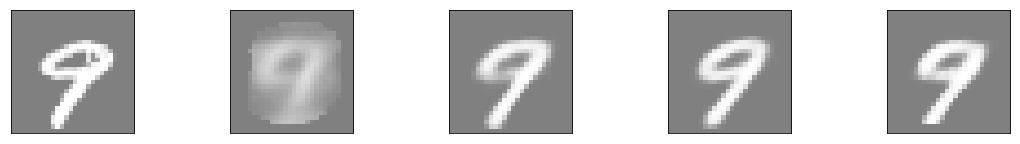

In [7]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1, shuffle=False, drop_last=True)
for j, data in enumerate(test_loader, 0):
    input = data[0].reshape(test_loader.batch_size, -1).to(device)
    
    rec1, _, _, _ = vae_model(input)
    rec2, _, _, _ = vae_model_beta05(input)
    rec3, _, _, _ = vae_model_beta1(input)
    rec4, _, _, _, _ = ivae_model(input)
    
    plot_gallery([data[0].numpy(), rec3.data.cpu().numpy(),
                  rec2.data.cpu().numpy(), 
                  rec1.data.cpu().numpy(), 
                  rec4[0, 0].data.cpu().numpy()], 28, 28, n_row=1, n_col=5)
    if (j >= 9):
        break

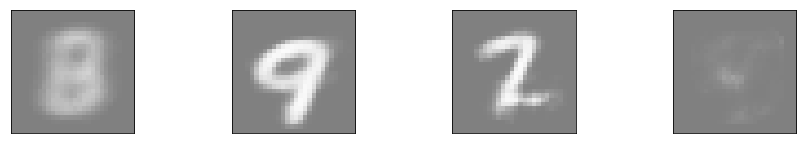

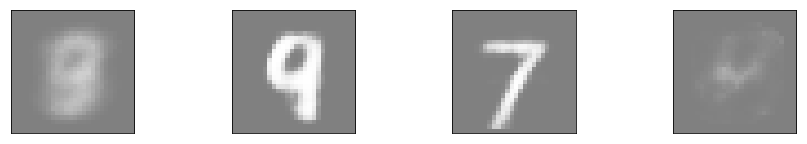

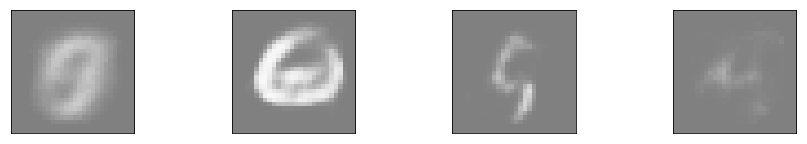

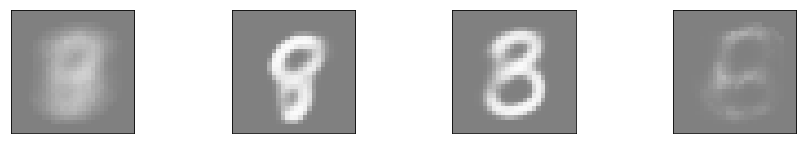

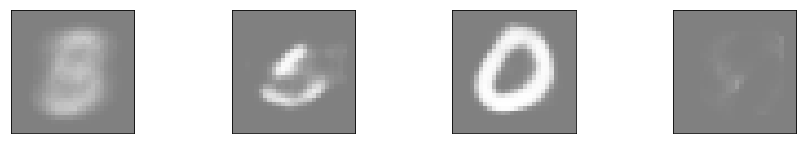

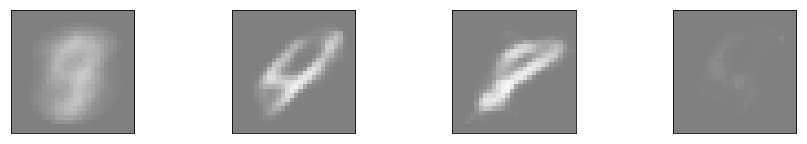

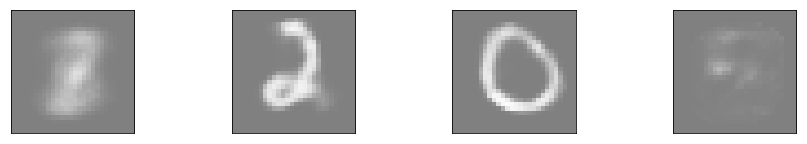

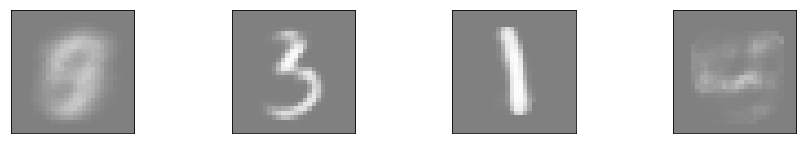

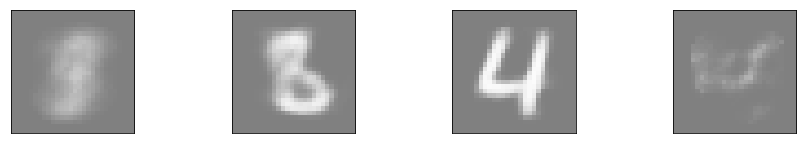

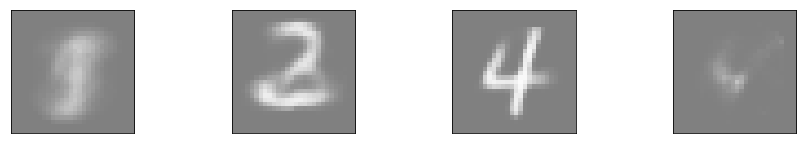

In [8]:
for j, data in enumerate(test_loader, 0):
    
    rec1 = sample_vae(200, vae_model)
    rec2 = sample_vae(200, vae_model_beta05)
    rec3 = sample_vae(200, vae_model_beta1)
    rec4 = sample_vae(200, ivae_model)
    
    plot_gallery([rec3.data.cpu().numpy(), rec2.data.cpu().numpy(),
                  rec1.data.cpu().numpy(), rec4.data.cpu().numpy()], 28, 28, n_row=1, n_col=4)
    if (j >= 9):
        break

In [9]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1, shuffle=False, drop_last=True)
print('VAE', marginal_KL(test_loader, vae_model_beta1).data.cpu())
print('Beta vae', marginal_KL(test_loader, vae_model_beta05).data.cpu())
print('GECO', marginal_KL(test_loader, vae_model).data.cpu())

VAE tensor(1.5813)
Beta vae tensor(10.5938)
GECO tensor(10.4975)


In [10]:
print('VAE',Compute_NLL(test_loader, vae_model_beta1).data.cpu())
print('Beta vae',Compute_NLL(test_loader, vae_model_beta05).data.cpu())
print('GECO',Compute_NLL(test_loader, vae_model).data.cpu())
# print('GECO IWAE',Compute_NLL_ivae(mnist_test_loader, ivae_model).data.cpu())

VAE tensor([55.8484])
Beta vae tensor([15.1434])
GECO tensor([14.6269])
